In [157]:
import time

from ib.opt import message
import numpy as np
import pandas as pd

import contracts
from settings import TWS_CONNECTION, company

In [316]:
class GetPutCallPrices():
    contract = None
    right = None
    prices_put = pd.DataFrame()
    prices_call = pd.DataFrame()
    prices_msg = pd.DataFrame()
    wait = 0.
    stop = False
    
    def __init__(self, company, expiration, strike):
        self.company = company
        self.expiration = expiration
        self.strike = strike

    def get_prices(self):
        TWS_CONNECTION.register(self.msg_handler, message.historicalData)
        TWS_CONNECTION.register(self.error_handler, message.Error)
#         TWS_CONNECTION.registerAll(print)
        self.get_put_prices()
        prices_put = self.prices_msg
        print(prices_put)
        self.prices_msg = pd.DataFrame()
        self.get_call_prices()
        prices_call = self.prices_msg
        # Merge PUT & CALL into one DateFrame
        result = prices_call.join(prices_put, how='outer', lsuffix='_left', rsuffix='_right')
        print(prices_call)
        print(result)
        return result
       
    def get_put_prices(self):
        self.right = 'P' # for the column name
        self.contract = contracts.PutOption(
            self.company,
            self.expiration,
            self.strike
        )
        self.request_prices()

    def get_call_prices(self):
        self.right = 'C' # for the column name
        self.contract = contracts.CallOption(
            self.company,
            self.expiration,
            self.strike
        )
        self.request_prices()
 
    def request_prices(self):
        TWS_CONNECTION.connect()
        TWS_CONNECTION.reqHistoricalData(
            1,
            self.contract,
            '',
            '1 W',
            '30 mins',
            "MIDPOINT",
            1,
            1
        )
        while not self.stop and self.wait < 30.:
            time.sleep(0.1)
            self.wait += 0.1
        TWS_CONNECTION.disconnect()
        self.wait = 0.
        self.stop = False
        
    def msg_handler(self, msg):
        """
        Function get message from TWS and put it into pandas DataFrame object
        :param msg: message from TWS
        :return: dataframe w/ historical prices
        """
        if 'finished' in msg.date:
            self.stop = True
            return None
        columns = pd.MultiIndex.from_product([[self.right], [self.expiration], [self.strike]])
        new_row = pd.DataFrame(msg.close, index=[msg.date], columns=columns)
        self.prices_msg = self.prices_msg.append(new_row)
    
    def error_handler(self, msg):
#         print(type(msg), msg)
        if msg.errorCode == 200:
            self.stop = True

In [100]:
index = ['Right', 'Expiration', 'Strike']
a = {
    'Datetime': '20191127  21:30:00',
    'Right': 'P',
    'Expiration': '20191206',
    'Strike': 300.,
    'Price': 0.37
}
b = {
    'Right': 'C',
    'Expiration': '20191206',
    'Strike': 300.,
    '20191127  21:30:00': 1.37
}
test = pd.DataFrame()

columns = pd.MultiIndex.from_product([[a['Right']], [a['Expiration']], [a['Strike']]])
a = pd.DataFrame(a['Price'], index=[a['Datetime']], columns=columns)
# a = pd.DataFrame(a, index=['Datetime'], columns='Price')# = [0]).set_index(['Right', 'Expiration', 'Strike'])
print(a)
b = pd.DataFrame(b, index = [0]).set_index(['Right', 'Expiration', 'Strike'])
# b
# test = test.append(a)
# test = test.append(b)
# # print(test)
# c = {
#     'Right': 'C',
#     'Expiration': '20191206',
#     'Strike': 300.,
#     '20191128  21:30:00': 5.23    # at the next day
# }
# c = pd.DataFrame(c, index = [0]).set_index(['Right', 'Expiration', 'Strike'])
# test = pd.concat([test, c], axis=1, sort=False)
# d = pd.DataFrame()
# test = pd.concat([test, d], axis=1, sort=False)
# e = {
#     'Right': 'C',
#     'Expiration': '20191206',
#     'Strike': 305,    # new strike
#     '20191128  21:30:00': 5.23
# }
# e = pd.DataFrame(e, index = [0]).set_index(['Right', 'Expiration', 'Strike'])
# test = pd.concat([test, e], axis=1, sort=False)
# print(test)

                          P
                   20191206
                      300.0
20191127  21:30:00     0.37


In [163]:
a = {
    'Datetime': '20191127  21:30:00',
    'Right': 'P',
    'Expiration': '20191206',
    'Strike': 300.,
    'Price': 0.37
}
b = {
    'Datetime': '20191127  21:30:00',
    'Right': 'C',
    'Expiration': '20191206',
    'Strike': 300.,
    'Price': 5.3
}
test = pd.DataFrame()

columns = pd.MultiIndex.from_product([[a['Right']], [a['Expiration']], [a['Strike']]])
a = pd.DataFrame(a['Price'], index=[a['Datetime']], columns=columns)
# print(a)
test = test.append(a)
columns = pd.MultiIndex.from_product([[b['Right']], [b['Expiration']], [b['Strike']]])
b = pd.DataFrame(b['Price'], index=[b['Datetime']], columns=columns)
# print(b)
test = test.append(b)
# print(test)

c = {
    'Datetime': '20191128  21:30:00', # new
    'Right': 'C',
    'Expiration': '20191206',
    'Strike': 300.,
    'Price': 16.3
}
columns = pd.MultiIndex.from_product([[c['Right']], [c['Expiration']], [c['Strike']]])
c = pd.DataFrame(c['Price'], index=[c['Datetime']], columns=columns)
test = test.append(c)

d = {
    'Datetime': '20191129  21:30:00',
    'Right': 'C',
    'Expiration': '20191206',
    'Strike': 305.,    # new
    'Price': 9.5
}
columns = pd.MultiIndex.from_product([[d['Right']], [d['Expiration']], [d['Strike']]])
d = pd.DataFrame(d['Price'], index=[d['Datetime']], columns=columns)
# test = pd.concat([test, d], axis=0, sort=False)



test = test.join(d, how='outer')
test





,C,P,C
,20191206,20191206,20191206
,300.0,300.0,305.0
20191127 21:30:00,NaN,0.37,NaN
20191127 21:30:00,5.3,NaN,NaN
20191128 21:30:00,16.3,NaN,NaN
20191129 21:30:00,NaN,NaN,9.5


In [131]:
prices = GetPutCallPrices(
    company,
    '20191227',   # 20220121
    300.0   # 420
).get_prices()
print(prices)
prices.index = pd.to_datetime(prices.index)
prices = prices.groupby(pd.Grouper(freq='D')).nth(-1) # convert to 1D timeframe

<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm co

<historicalData reqId=1, date=20191127  21:30:00, open=3.2, high=3.2, low=3.2, close=3.2, volume=0, count=0, WAP=3.2, hasGaps=False>
<historicalData reqId=1, date=20191127  22:00:00, open=3.33, high=3.33, low=3.25, close=3.25, volume=116, count=8, WAP=3.324, hasGaps=False>
<historicalData reqId=1, date=20191127  22:30:00, open=3.2, high=3.2, low=3.2, close=3.2, volume=10, count=1, WAP=3.2, hasGaps=False>
<historicalData reqId=1, date=20191127  23:00:00, open=2.95, high=2.95, low=2.95, close=2.95, volume=2, count=2, WAP=2.95, hasGaps=False>
<historicalData reqId=1, date=20191127  23:30:00, open=2.95, high=2.95, low=2.95, close=2.95, volume=0, count=0, WAP=2.95, hasGaps=False>
<historicalData reqId=1, date=20191129  17:30:00, open=3.38, high=3.38, low=3.38, close=3.38, volume=1, count=1, WAP=3.38, hasGaps=False>
<historicalData reqId=1, date=20191129  18:00:00, open=3.38, high=3.38, low=3.38, close=3.38, volume=0, count=0, WAP=3.38, hasGaps=False>
<historicalData reqId=1, date=20191129  

<historicalData reqId=1, date=20191126  21:00:00, open=35.75, high=35.75, low=35.75, close=35.75, volume=0, count=0, WAP=35.75, hasGaps=False>
<historicalData reqId=1, date=20191126  21:30:00, open=35.75, high=35.75, low=35.75, close=35.75, volume=0, count=0, WAP=35.75, hasGaps=False>
<historicalData reqId=1, date=20191126  22:00:00, open=32.0, high=32.0, low=32.0, close=32.0, volume=10, count=1, WAP=32.0, hasGaps=False>
<historicalData reqId=1, date=20191126  22:30:00, open=32.0, high=32.0, low=32.0, close=32.0, volume=0, count=0, WAP=32.0, hasGaps=False>
<historicalData reqId=1, date=20191126  23:00:00, open=31.55, high=31.55, low=31.55, close=31.55, volume=3, count=1, WAP=31.55, hasGaps=False>
<historicalData reqId=1, date=20191126  23:30:00, open=31.5, high=32.6, low=31.5, close=32.6, volume=6, count=4, WAP=32.05, hasGaps=False>
<historicalData reqId=1, date=20191127  17:30:00, open=35.0, high=35.0, low=34.84, close=34.84, volume=4, count=3, WAP=34.88, hasGaps=False>
<historicalDat

In [132]:
prices

,C,P
,20191227,20191227
,300.0,300.0
2019-11-25,41.08,3.15
2019-11-26,32.60,3.50
2019-11-27,33.19,2.95
2019-11-29,33.00,3.38


In [231]:
# %matplotlib inline
import matplotlib.pyplot as plt

import logging
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.ERROR)

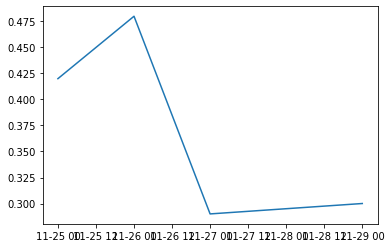

In [38]:
plt.plot(prices['P'])
plt.show()

In [154]:
# Look for all strikes and expirations
from ib.ext.ContractDetails import ContractDetails
from ib.ext.EClientSocket import EClientSocket
from ib.opt import message


class OptionChain():
    options = []
    wait = 0.
    stop = False
    
    def __init__(self, company):
        self.contract = contracts.CallOption(
            company,
            None,
            None
        )
    
    def get_options(self):
        #     TWS_CONNECTION.registerAll(print)
        TWS_CONNECTION.register(self.msg_handler, 'ContractDetails')
        TWS_CONNECTION.register(self.msg_stopper, 'ContractDetailsEnd')
        TWS_CONNECTION.connect()
        EClientSocket.reqContractDetails(TWS_CONNECTION, 2, self.contract)
        while not self.stop and self.wait < 30.:
            time.sleep(0.1)
            self.wait += 0.1
        TWS_CONNECTION.disconnect()
        return self.options

    def msg_stopper(self, msg):
        if msg:
            self.stop = True
        
    def msg_handler(self, msg):
        self.options.append({
            'strike': msg.contractDetails.m_summary.m_strike,
            'expiration': msg.contractDetails.m_summary.m_expiry
        })

In [90]:
options = OptionChain(company).get_options()
options

<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2158, errorMsg=Sec-def

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11dad95c0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11dad95c0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11dad95c0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11dad9d68>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11dad9d68>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11dad9d68>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11dad9fd0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11dad9fd0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11dad9fd0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c7b6f98>>
<contractDetails reqId=2, contractDetails=<ib.

<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.

01-Dec-19 16:02:16 ERROR     Exception in message dispatch.  Handler 'msg_stopper' for 'contractDetailsEnd'
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ib/opt/dispatcher.py", line 44, in __call__
    results.append(listener(message))
  File "<ipython-input-45-e8721e55399c>", line 18, in msg_stopper
    if type(msgs) == message.contractDetailsEnd:
NameError: name 'msgs' is not defined
01-Dec-19 16:02:16 ERROR     Exception in message dispatch.  Handler 'msg_stopper' for 'contractDetailsEnd'
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ib/opt/dispatcher.py", line 44, in __call__
    results.append(listener(message))
  File "<ipython-input-73-ec08a3f46304>", line 19, in msg_stopper
    print(f'Stop: {stop}, Wait: {wait}')
UnboundLocalError: local variable 'stop' referenced before assignment


<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetails reqId=2, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11c38cef0>>
<contractDetailsEnd reqId=2>
<contractDetailsEnd reqId=2>
<contractDetailsEnd reqId=2>


	!!! STOP!!!




	!!! STOP!!!




	!!! STOP!!!




[{'strike': 175.0, 'expiration': '20200117'},
 {'strike': 180.0, 'expiration': '20200117'},
 {'strike': 185.0, 'expiration': '20200117'},
 {'strike': 190.0, 'expiration': '20200117'},
 {'strike': 195.0, 'expiration': '20200117'},
 {'strike': 200.0, 'expiration': '20200117'},
 {'strike': 210.0, 'expiration': '20200117'},
 {'strike': 220.0, 'expiration': '20200117'},
 {'strike': 230.0, 'expiration': '20200117'},
 {'strike': 240.0, 'expiration': '20200117'},
 {'strike': 250.0, 'expiration': '20200117'},
 {'strike': 255.0, 'expiration': '20200117'},
 {'strike': 260.0, 'expiration': '20200117'},
 {'strike': 265.0, 'expiration': '20200117'},
 {'strike': 270.0, 'expiration': '20200117'},
 {'strike': 275.0, 'expiration': '20200117'},
 {'strike': 280.0, 'expiration': '20200117'},
 {'strike': 285.0, 'expiration': '20200117'},
 {'strike': 290.0, 'expiration': '20200117'},
 {'strike': 295.0, 'expiration': '20200117'},
 {'strike': 300.0, 'expiration': '20200117'},
 {'strike': 305.0, 'expiration': '

In [160]:
options

[{'strike': 175.0, 'expiration': '20200117'},
 {'strike': 180.0, 'expiration': '20200117'},
 {'strike': 185.0, 'expiration': '20200117'},
 {'strike': 190.0, 'expiration': '20200117'},
 {'strike': 195.0, 'expiration': '20200117'},
 {'strike': 200.0, 'expiration': '20200117'},
 {'strike': 210.0, 'expiration': '20200117'},
 {'strike': 220.0, 'expiration': '20200117'},
 {'strike': 230.0, 'expiration': '20200117'},
 {'strike': 240.0, 'expiration': '20200117'},
 {'strike': 250.0, 'expiration': '20200117'},
 {'strike': 255.0, 'expiration': '20200117'},
 {'strike': 260.0, 'expiration': '20200117'},
 {'strike': 265.0, 'expiration': '20200117'},
 {'strike': 270.0, 'expiration': '20200117'},
 {'strike': 275.0, 'expiration': '20200117'},
 {'strike': 280.0, 'expiration': '20200117'},
 {'strike': 285.0, 'expiration': '20200117'},
 {'strike': 290.0, 'expiration': '20200117'},
 {'strike': 295.0, 'expiration': '20200117'},
 {'strike': 300.0, 'expiration': '20200117'},
 {'strike': 305.0, 'expiration': '

In [106]:
a = pd.DataFrame()
prices2 = prices.copy()
b = pd.concat([prices, a])
print(b)

                  C        P
           20191206 20191206
                300      300
2019-11-25    38.95     0.42
2019-11-26    28.65     0.48
2019-11-27    30.15     0.29
2019-11-29    30.20     0.30


In [317]:
# options = OptionChain(company).get_options()
result = pd.DataFrame()
i = 0
for option in options[:2]:
    print(option)
    new_prices = GetPutCallPrices(
        company,
        option['expiration'],
        option['strike']
    ).get_prices()
    if i == 0:
        result = new_prices
        result.index = pd.to_datetime(result.index)
#         
    else:
        result = result.join(new_prices, how='outer')
        result.index = pd.to_datetime(result.index)
#         result = result.groupby(pd.Grouper(freq='D')).nth(-1) # convert to 1D timeframe
    i += 1
result

{'strike': 175.0, 'expiration': '20200117'}
<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1

<historicalData reqId=1, date=20191125  17:30:00, open=0.52, high=0.81, low=0.34, close=0.34, volume=-1, count=-1, WAP=-1.0, hasGaps=False>
<historicalData reqId=1, date=20191125  18:00:00, open=0.34, high=0.355, low=0.34, close=0.355, volume=-1, count=-1, WAP=-1.0, hasGaps=False>
<historicalData reqId=1, date=20191125  18:30:00, open=0.355, high=0.355, low=0.345, close=0.35, volume=-1, count=-1, WAP=-1.0, hasGaps=False>
<historicalData reqId=1, date=20191125  19:00:00, open=0.35, high=0.35, low=0.335, close=0.35, volume=-1, count=-1, WAP=-1.0, hasGaps=False>
<historicalData reqId=1, date=20191125  19:30:00, open=0.35, high=0.365, low=0.345, close=0.345, volume=-1, count=-1, WAP=-1.0, hasGaps=False>
<historicalData reqId=1, date=20191125  20:00:00, open=0.345, high=0.345, low=0.325, close=0.33, volume=-1, count=-1, WAP=-1.0, hasGaps=False>
<historicalData reqId=1, date=20191125  20:30:00, open=0.33, high=0.33, low=0.315, close=0.33, volume=-1, count=-1, WAP=-1.0, hasGaps=False>
<histor

<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib

                          C
                   20200117
                      175.0
20191129  20:30:00    0.295
                          C        P
                   20200117 20200117
                      175.0    175.0
20191125  17:30:00      NaN    0.340
20191125  18:00:00      NaN    0.355
20191125  18:30:00      NaN    0.350
20191125  19:00:00      NaN    0.350
20191125  19:30:00      NaN    0.345
20191125  20:00:00      NaN    0.330
20191125  20:30:00      NaN    0.330
20191125  21:00:00      NaN    0.335
20191125  21:30:00      NaN    0.335
20191125  22:00:00      NaN    0.335
20191125  22:30:00      NaN    0.330
20191125  23:00:00      NaN    0.330
20191125  23:30:00      NaN    0.310
20191126  17:30:00      NaN    0.340
20191126  18:00:00      NaN    0.340
20191126  18:30:00      NaN    0.325
20191126  19:00:00      NaN    0.310
20191126  19:30:00      NaN    0.305
20191126  20:00:00      NaN    0.305
20191126  20:30:00      NaN    0.305
20191126  21:00:00      NaN    0.310


<historicalData reqId=1, date=20191125  17:30:00, open=0.53, high=0.92, low=0.375, close=0.38, volume=-1, count=-1, WAP=-1.0, hasGaps=False>
<historicalData reqId=1, date=20191125  18:00:00, open=0.38, high=0.395, low=0.375, close=0.395, volume=-1, count=-1, WAP=-1.0, hasGaps=False>
<historicalData reqId=1, date=20191125  18:30:00, open=0.395, high=0.4, low=0.39, close=0.4, volume=-1, count=-1, WAP=-1.0, hasGaps=False>
<historicalData reqId=1, date=20191125  19:00:00, open=0.4, high=0.415, low=0.345, close=0.395, volume=-1, count=-1, WAP=-1.0, hasGaps=False>
<historicalData reqId=1, date=20191125  19:30:00, open=0.395, high=0.395, low=0.375, close=0.375, volume=-1, count=-1, WAP=-1.0, hasGaps=False>
<historicalData reqId=1, date=20191125  20:00:00, open=0.375, high=0.375, low=0.365, close=0.37, volume=-1, count=-1, WAP=-1.0, hasGaps=False>
<historicalData reqId=1, date=20191125  20:30:00, open=0.37, high=0.37, low=0.365, close=0.37, volume=-1, count=-1, WAP=-1.0, hasGaps=False>
<histor

<historicalData reqId=1, date=20191125  17:30:00, open=164.6, high=164.6, low=158.85, close=162.275, volume=-1, count=-1, WAP=-1.0, hasGaps=False>
<historicalData reqId=1, date=20191125  18:00:00, open=162.275, high=163.2, low=160.35, close=161.05, volume=-1, count=-1, WAP=-1.0, hasGaps=False>
<historicalData reqId=1, date=20191125  18:30:00, open=161.05, high=162.05, low=156.6, close=156.75, volume=-1, count=-1, WAP=-1.0, hasGaps=False>
<historicalData reqId=1, date=20191125  19:00:00, open=156.75, high=158.35, low=156.275, close=157.525, volume=-1, count=-1, WAP=-1.0, hasGaps=False>
<historicalData reqId=1, date=20191125  19:30:00, open=157.525, high=158.25, low=155.75, close=157.6, volume=-1, count=-1, WAP=-1.0, hasGaps=False>
<historicalData reqId=1, date=20191125  20:00:00, open=157.6, high=158.8, low=156.825, close=158.575, volume=-1, count=-1, WAP=-1.0, hasGaps=False>
<historicalData reqId=1, date=20191125  20:30:00, open=158.575, high=159.0, low=156.725, close=157.125, volume=-

,C,P,C,P
,20200117,20200117,20200117,20200117
,175.0,175.0,180.0,180.0
2019-11-25 17:30:00,NaN,0.340,162.275,0.380
2019-11-25 18:00:00,NaN,0.355,161.050,0.395
2019-11-25 18:30:00,NaN,0.350,156.750,0.400
2019-11-25 19:00:00,NaN,0.350,157.525,0.395
2019-11-25 19:30:00,NaN,0.345,157.600,0.375
2019-11-25 20:00:00,NaN,0.330,158.575,0.370
2019-11-25 20:30:00,NaN,0.330,157.125,0.370
2019-11-25 21:00:00,NaN,0.335,157.625,0.370


In [318]:
result

,C,P,C,P
,20200117,20200117,20200117,20200117
,175.0,175.0,180.0,180.0
2019-11-25 17:30:00,NaN,0.340,162.275,0.380
2019-11-25 18:00:00,NaN,0.355,161.050,0.395
2019-11-25 18:30:00,NaN,0.350,156.750,0.400
2019-11-25 19:00:00,NaN,0.350,157.525,0.395
2019-11-25 19:30:00,NaN,0.345,157.600,0.375
2019-11-25 20:00:00,NaN,0.330,158.575,0.370
2019-11-25 20:30:00,NaN,0.330,157.125,0.370
2019-11-25 21:00:00,NaN,0.335,157.625,0.370


In [319]:
res2 = result.groupby(pd.Grouper(freq='D')).nth(-1) # convert to 1D timeframe
res2

,C,P,C,P
,20200117,20200117,20200117,20200117
,175.0,175.0,180.0,180.0
2019-11-25,NaN,0.310,156.525,0.360
2019-11-26,NaN,0.335,149.100,0.295
2019-11-27,NaN,0.295,151.000,0.340
2019-11-29,0.295,NaN,150.275,0.320


In [229]:
res2.loc[:,res2.columns.get_level_values(2) > 300.]

P        C        P        C        P        C        P  \
           20191206 20191206 20191206 20191206 20191206 20191206 20191206   
              302.5    307.5    307.5    312.5    312.5    317.5    317.5   
2019-11-25     0.58      NaN     1.13    29.90     1.75    22.25     2.07   
2019-11-26     0.60     22.4     0.99      NaN     1.55    16.43     2.52   
2019-11-27     0.36      NaN     0.54    18.15     0.91    14.05     1.61   
2019-11-29     0.32      NaN     0.54    18.40     0.90    12.50     1.52   

                  C        P        C  ...                                   \
           20191206 20191206 20191206  ... 20191213                           
              322.5    322.5    327.5  ...    410.0 415.0 420.0 425.0 430.0   
2019-11-25    17.65     3.05    13.45  ...     0.30  0.30  0.21  0.17  0.17   
2019-11-26    10.44     3.95     7.35  ...     0.12  0.16  0.09  0.10   NaN   
2019-11-27    11.40     2.60     8.20  ...      NaN   NaN  0.10   NaN   NaN   
2019-11-29     9.95     2.58     6.80  ...      NaN  0.07   NaN   NaN  0.03   

                                             P  
                             20191227 20191227  
           440.0 445.0 450.0    302.5    302.5  
2019-11-25  0.14  0.13   NaN    39.02      NaN  
2019-11-26  0.06  0.03  0.03      NaN     3.55  
2019-11-27   NaN   NaN   NaN      NaN      NaN  
2019-11-29   NaN   NaN   NaN      NaN      NaN  

[4 rows x 87 columns]

In [246]:
df_to_show = res2.loc[:,res2.columns.get_level_values(2) > 300.]
df_to_show.columns.levels[2]

Float64Index([200.0, 210.0, 220.0, 225.0, 230.0, 235.0, 240.0, 245.0, 250.0,
              255.0, 260.0, 265.0, 270.0, 275.0, 277.5, 280.0, 282.5, 285.0,
              287.5, 290.0, 292.5, 295.0, 297.5, 300.0, 302.5, 305.0, 307.5,
              310.0, 312.5, 315.0, 317.5, 320.0, 322.5, 325.0, 327.5, 330.0,
              332.5, 335.0, 337.5, 340.0, 342.5, 345.0, 347.5, 350.0, 355.0,
              360.0, 365.0, 370.0, 375.0, 380.0, 385.0, 390.0, 395.0, 400.0,
              405.0, 410.0, 415.0, 420.0, 425.0, 430.0, 440.0, 445.0, 450.0],
             dtype='float64')

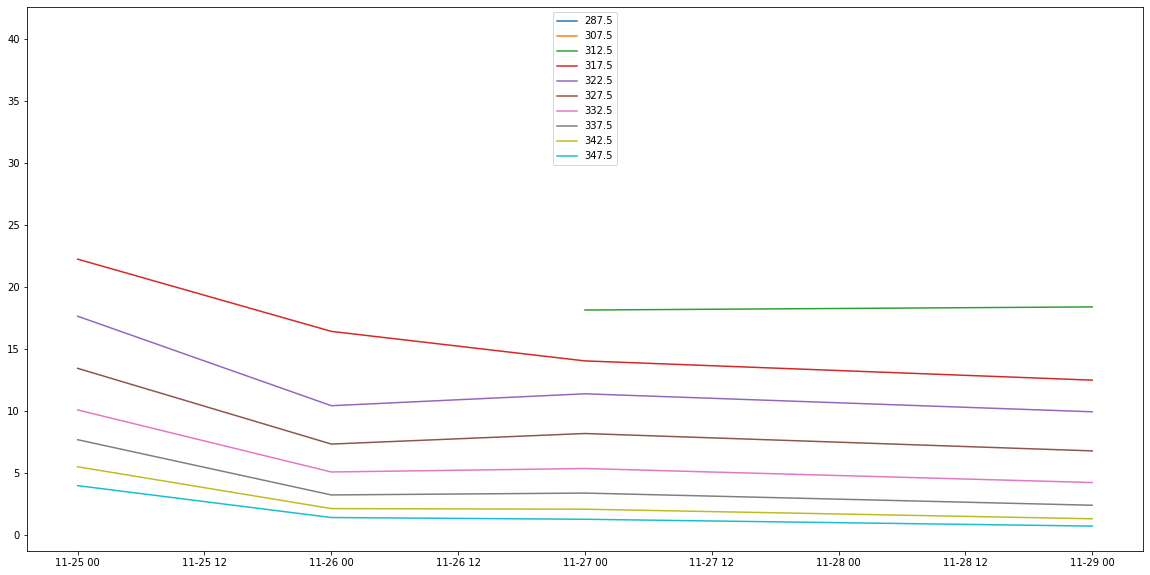

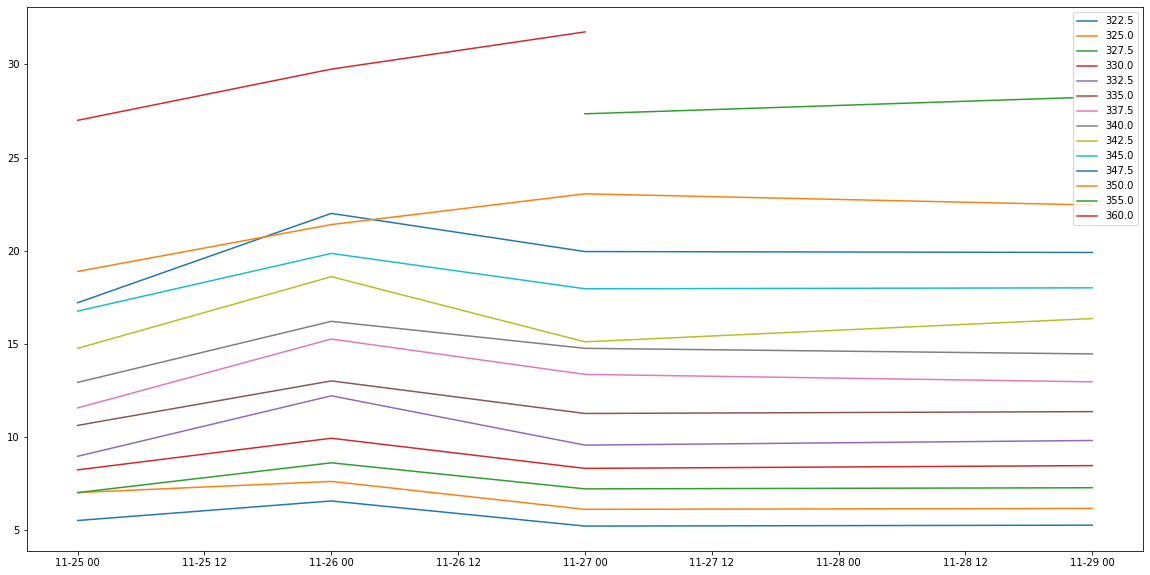

                  C        P                          C        P        C  \
           20191206 20191206                   20191206 20191206 20191206   
              287.5    287.5 292.5 297.5 302.5    307.5    307.5    312.5   
2019-11-25      NaN     0.17  0.26  0.38  0.58      NaN     1.13    29.90   
2019-11-26      NaN     0.22  0.30  0.45  0.60     22.4     0.99      NaN   
2019-11-27      NaN     0.15  0.20  0.24  0.36      NaN     0.54    18.15   
2019-11-29    40.56     0.16  0.20  0.25  0.32      NaN     0.54    18.40   

                  P        C  ...        P                    C        P  \
           20191206 20191206  ... 20191227             20191227 20191227   
              312.5    317.5  ...    280.0 285.0 290.0    295.0    295.0   
2019-11-25     1.75    22.25  ...     1.20  1.56  1.99    45.84     2.32   
2019-11-26     1.55    16.43  ...     1.37  1.73  2.30      NaN     2.81   
2019-11-27     0.91    14.05  ...     1.15  1.46  1.93      NaN     2.58   
2019

In [311]:
plt.rcParams['figure.figsize'] = [20, 10]

# df_to_show = res2['P']['20191213']
# df_to_show = df_to_show[df_to_show > 250.0]

# Draw CALL options
exp = '20191206' # 20191206, 20191213, 20191227
call_options = res2['C'][exp].loc[:,res2['C'][exp].columns.get_level_values(0) > 250.]
call_options = call_options.loc[:,call_options.columns < 351.]
plt.plot(call_options)
plt.legend(call_options.columns)
plt.show()

# Draw PUT options
exp = '20191213' # 20191206, 20191213, 20191227
put_options = res2['P'][exp].loc[:,res2['P'][exp].columns.get_level_values(0) > 320.]
put_options = put_options.loc[:,put_options.columns < 361.]
plt.plot(put_options)
plt.legend(put_options.columns)
plt.title = 'PUT'
plt.show()
print(res2)
print(np.flip(put_options.columns.values))

In [312]:
! git commit -a -m 'In work'
! git push

[version_2 117ae56] In work
 3 files changed, 21332 insertions(+), 6595 deletions(-)
 rewrite .ipynb_checkpoints/test-checkpoint.ipynb (67%)
 rewrite test.ipynb (67%)
Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 4 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (5/5), 132.66 KiB | 8.84 MiB/s, done.
Total 5 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/SVGalich/tws_trader.git
   5ad6787..117ae56  version_2 -> version_2


## Гипотезы
1. Пересечение прямых Пут-Страйк различных дат экспирации: сигнал для сделки! Происходят при резких колебаниях underlying актива.